In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import keras
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix



In [5]:
train_dir = 'C://Users//user//Computer Science Projects//CSC462//Course Project//Date_Fruit_Image_Dataset_Splitted_Train//train'
test_dir = 'C://Users//user//Computer Science Projects//CSC462//Course Project//Date_Fruit_Image_Dataset_Splitted_Test//test'


In [6]:
# Check the contents of the train directory
train_classes = os.listdir(train_dir)
print("Classes in the train directory:")
trainCounter = 0
testCounter = 0
for class_name in train_classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        trainCounter = trainCounter + len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")


# Check the contents of the test directory
test_classes = os.listdir(test_dir)
print("\nClasses in the test directory:")
for class_name in test_classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))      
        trainCounter = trainCounter + len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
        
print(f"\nNumber of train classes {len(train_classes)}\nNumber of test classes {len(test_classes)}")

Classes in the train directory:
Ajwa: 122 images
Galaxy: 133 images
Mejdool: 94 images
Meneifi: 162 images
NabtatAli: 123 images
Rutab: 102 images
Shaishe: 119 images
Sokari: 184 images
Sugaey: 117 images

Classes in the test directory:
Ajwa: 53 images
Galaxy: 57 images
Mejdool: 41 images
Meneifi: 70 images
NabtatAli: 54 images
Rutab: 44 images
Shaishe: 52 images
Sokari: 80 images
Sugaey: 51 images

Number of train classes 9
Number of test classes 9


In [7]:
def count_images(directory):
    counts = {}
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

In [8]:
'''
A helper function to plot both train and test'''
def generate_plots(data_counts, title_suffix):
    classes = sorted(data_counts.keys())  # Ensure consistent order
    values = [data_counts[cls] for cls in classes]
    total_images = sum(values)
    ratios = [value / total_images * 100 for value in values]

    # Bar Graph for Class Counts
    fig, ax = plt.subplots(figsize=(12, 7))
    colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(classes)))
    bars = ax.bar(classes, values, color=colors, edgecolor='black')
    ax.set_title(f'Number of Images per Class in {title_suffix}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Number of Images', fontsize=14)
    ax.set_xticklabels(classes, rotation=45)
    ax.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # Vertical alignment

    # Pie Chart for Class Ratios
    fig, ax = plt.subplots(figsize=(12, 8))
    wedges, texts, autotexts = ax.pie(ratios, labels=classes, autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis(np.linspace(0.3, 0.75, len(classes))))
    ax.set_title(f'Class Distribution as Percentage of Total in {title_suffix}', fontsize=16, fontweight='bold')
    plt.setp(autotexts, size=10, weight="bold", color="white")

    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13616\2583994616.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45)


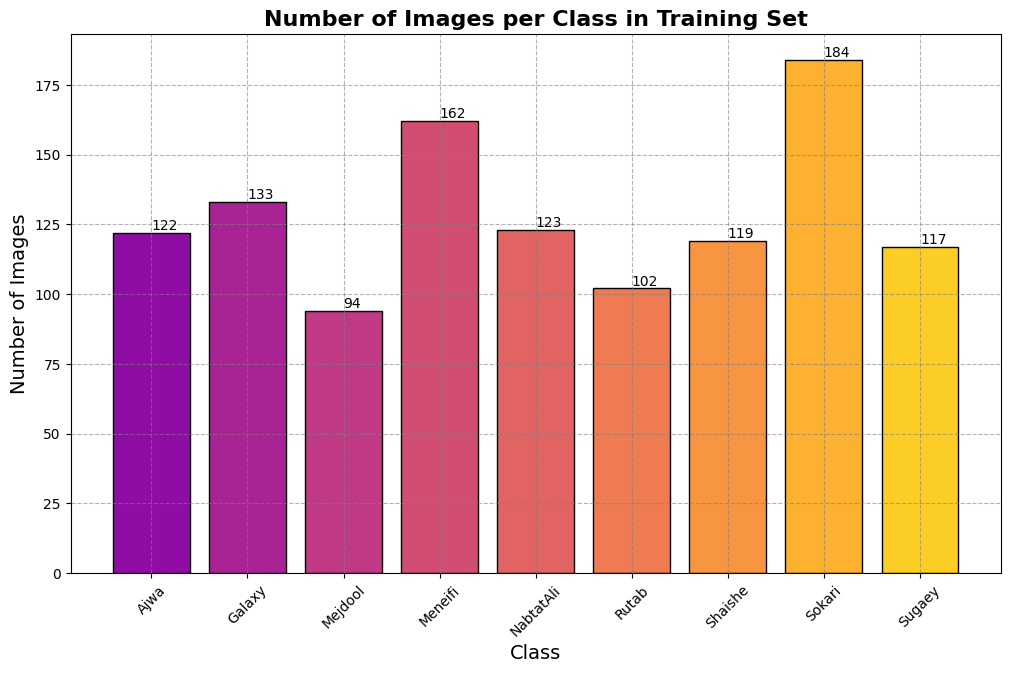

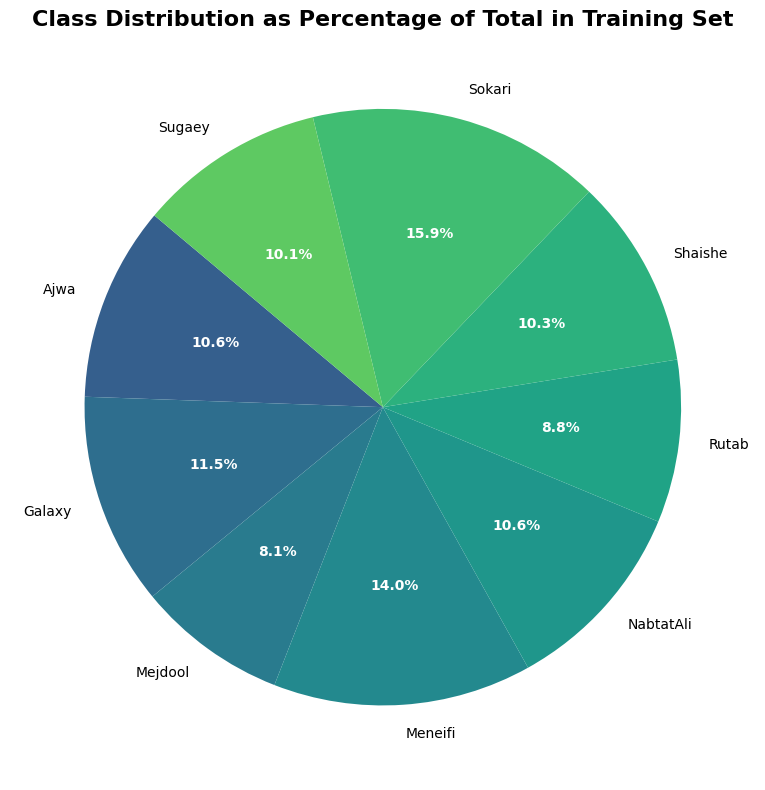

C:\Users\user\AppData\Local\Temp\ipykernel_13616\2583994616.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45)


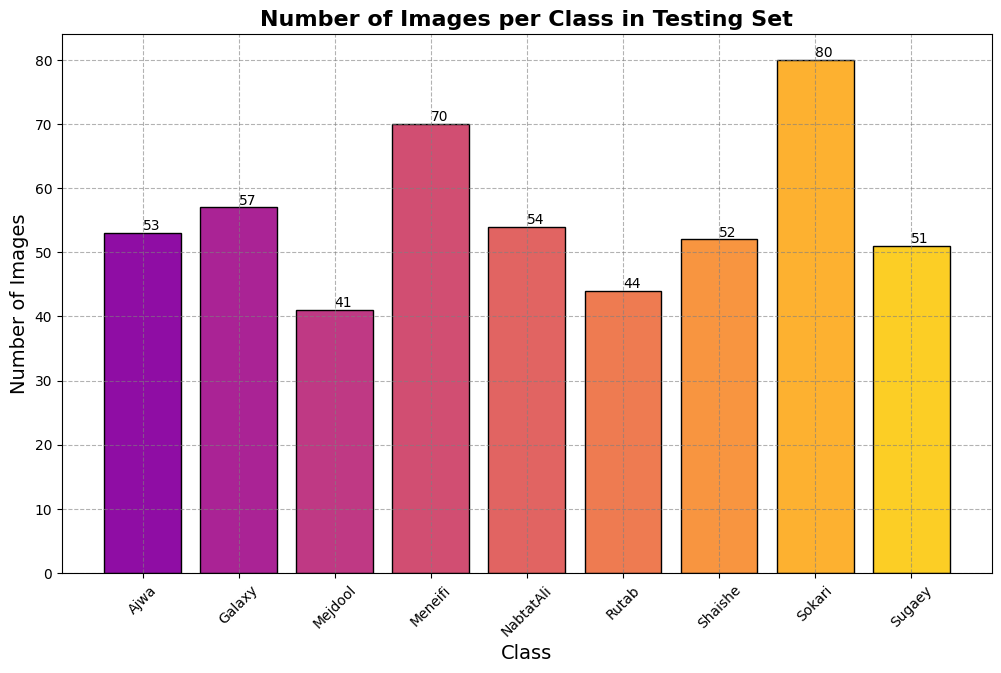

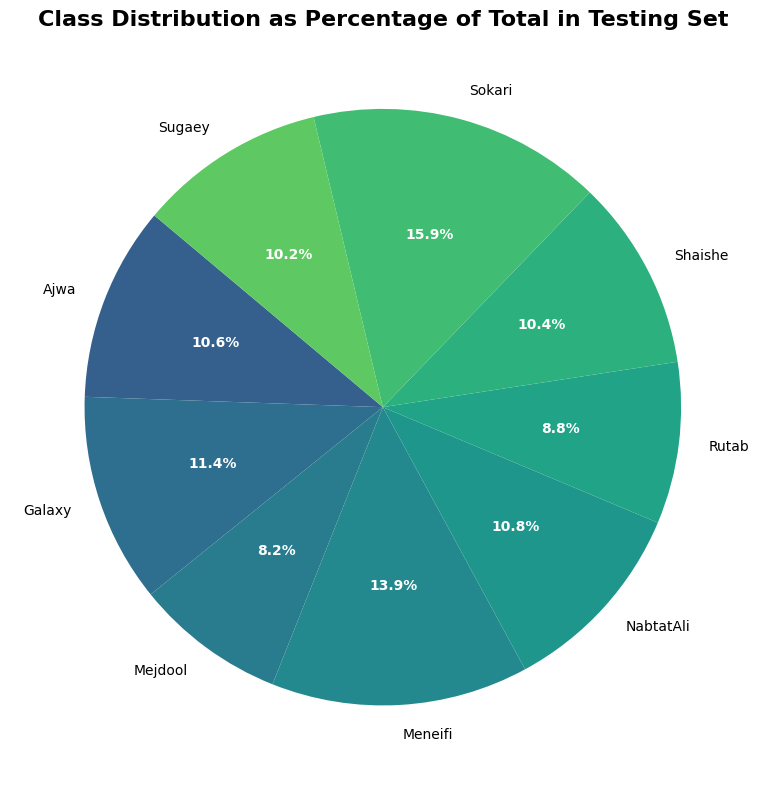

In [9]:
generate_plots(train_counts, 'Training Set')
generate_plots(test_counts, 'Testing Set')

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,  #  rotation range
    width_shift_range=0.1,  # width shift range
    height_shift_range=0.1,  # height shift range
    shear_range=0.1,  #  shear range
    zoom_range=0.1,  #  zoom range
    horizontal_flip=True,  #  horizontal flipping
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the training data for validation
)

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers initially, later on we'll unfreeze some(needed ones)
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Add custom layers on top of VGG16
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(train_classes), activation='softmax')  # Adjust number of classes
])


In [13]:
# By setting the subset parameter we are picking which set this will be, e.g. validation will pick 20 percent
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use the remaining 80% for training
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the 20% for validation
)


Found 930 images belonging to 9 classes.
Found 226 images belonging to 9 classes.


In [14]:
# Start training with non-trainable VGG16 layers
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10) # to use later on for some performance metrics

Epoch 1/10


30/30 [==============================] - 51s 2s/step - loss: 2.2237 - accuracy: 0.1677 - val_loss: 1.9989 - val_accuracy: 0.1593
Epoch 2/10
30/30 [==============================] - 51s 2s/step - loss: 1.9819 - accuracy: 0.2914 - val_loss: 1.7473 - val_accuracy: 0.4823
Epoch 3/10
30/30 [==============================] - 51s 2s/step - loss: 1.7195 - accuracy: 0.4247 - val_loss: 1.5898 - val_accuracy: 0.4956
Epoch 4/10
30/30 [==============================] - 50s 2s/step - loss: 1.5492 - accuracy: 0.5118 - val_loss: 1.4029 - val_accuracy: 0.6504
Epoch 5/10
30/30 [==============================] - 51s 2s/step - loss: 1.3730 - accuracy: 0.5774 - val_loss: 1.2591 - val_accuracy: 0.6327
Epoch 6/10
30/30 [==============================] - 52s 2s/step - loss: 1.2428 - accuracy: 0.6366 - val_loss: 1.1559 - val_accuracy: 0.6549
Epoch 7/10
30/30 [==============================] - 53s 2s/step - loss: 1.1889 - accuracy: 0.6204 - val_loss: 1.1046 - val_accuracy: 0.6726
Epoch 8/10
30/30 [

In [16]:
# Unfreeze some of the top layers of the model
for layer in base_model.layers[-6:]:
    layer.trainable = True

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Continue training with some layers, unfreezed layers
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
30/30 [==============================] - 69s 2s/step - loss: 0.7149 - accuracy: 0.7753 - val_loss: 0.6358 - val_accuracy: 0.8097
Epoch 2/20
30/30 [==============================] - 71s 2s/step - loss: 0.5723 - accuracy: 0.8215 - val_loss: 0.4844 - val_accuracy: 0.8407
Epoch 3/20
30/30 [==============================] - 69s 2s/step - loss: 0.4543 - accuracy: 0.8667 - val_loss: 0.4494 - val_accuracy: 0.8584
Epoch 4/20
30/30 [==============================] - 67s 2s/step - loss: 0.4033 - accuracy: 0.8785 - val_loss: 0.3702 - val_accuracy: 0.8805
Epoch 5/20
30/30 [==============================] - 68s 2s/step - loss: 0.3764 - accuracy: 0.8710 - val_loss: 0.3851 - val_accuracy: 0.8584
Epoch 6/20
30/30 [==============================] - 68s 2s/step - loss: 0.3196 - accuracy: 0.9043 - val_loss: 0.3351 - val_accuracy: 0.8938
Epoch 7/20
30/30 [==============================] - 68s 2s/step - loss: 0.3270 - accuracy: 0.8828 - val_loss: 0.4093 - val_accuracy: 0.8628
Epoch 8/20
30/30 [==

In [19]:
# Evaluate the model on the separate test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
   # shuffle = False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 502 images belonging to 9 classes.
16/16 [==============================] - 21s 1s/step - loss: 0.1748 - accuracy: 0.9382
Test Loss: 0.17483660578727722
Test Accuracy: 0.93824702501297


In [20]:
true_labels = []
predicted_labels = []

for images, labels in test_generator:
    true_labels.extend(labels.argmax(axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(predictions.argmax(axis=1))
    if len(true_labels) >= len(test_generator.filenames):
        break

1/1 [==============================] - 1s 1s/step


Classification Report:
              precision    recall  f1-score   support

        Ajwa       0.98      1.00      0.99        53
      Galaxy       0.92      0.96      0.94        57
     Mejdool       0.93      0.95      0.94        41
     Meneifi       0.88      0.87      0.88        70
   NabtatAli       0.96      0.94      0.95        54
       Rutab       0.90      1.00      0.95        44
     Shaishe       0.98      0.90      0.94        52
      Sokari       0.97      0.90      0.94        80
      Sugaey       0.92      0.96      0.94        51

    accuracy                           0.94       502
   macro avg       0.94      0.94      0.94       502
weighted avg       0.94      0.94      0.94       502



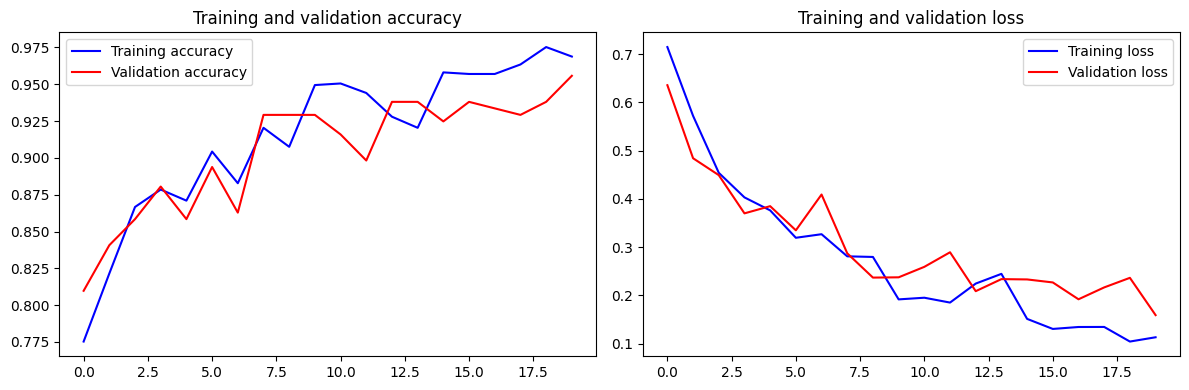

In [21]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

cm = confusion_matrix(true_labels, predicted_labels)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

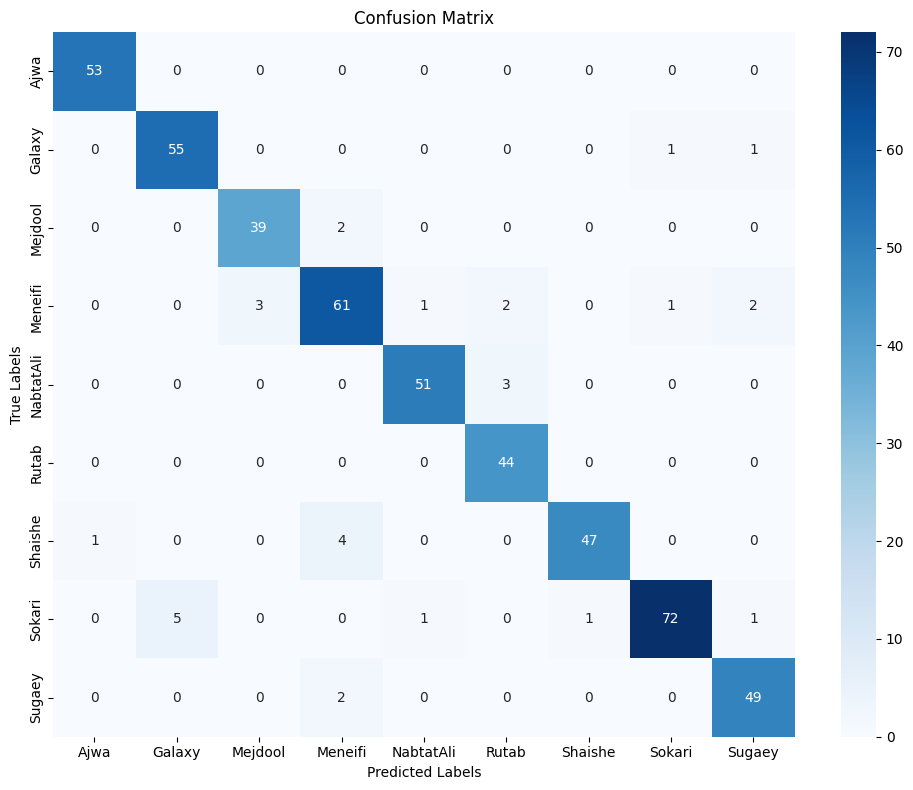

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()